In [2]:
import numpy as np
import pandas as pd
import geojson
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
from skimage import draw
import geopandas as gpd
from shapely import geometry, ops
import rasterio
from rasterio import features
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set()
sns.set_palette('husl', 8)




/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the prefe

In [3]:
points = pd.read_csv('POIs_RE_3p.csv')
location ='Lukulu'
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1]),
                   (points.xcoord[2],points.ycoord[2])]
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4]),
#                    (points.xcoord[5],points.ycoord[5]) ]
x, y = zip(*points_interest)

In [4]:
grid = Grid.from_raster('/Users/oscarkeunen/Downloads/s15e020_con_grid/s15e020_con/s15e020_con', data_name='dem')
grid1 = Grid.from_raster('/Users/oscarkeunen/Downloads/s20e020_con_grid/s20e020_con/s20e020_con', data_name='dem1')

grid.read_raster('/Users/oscarkeunen/Downloads/s15e020_dir_grid/s15e020_dir/s15e020_dir', data_name='dir')
grid.read_raster('/Users/oscarkeunen/Downloads/s20e020_dir_grid/s20e020_dir/s20e020_dir', data_name='dir1')

grid.accumulation(data='dir', out_name='acc')
grid.accumulation(data= grid.dir1, out_name='acc1')




In [5]:
hand = grid.compute_hand('dir', 'dem', grid.acc > 100, inplace=False)

hand1 = grid.compute_hand(grid.dir1, grid1.dem1, grid.acc1> 100, inplace=False)


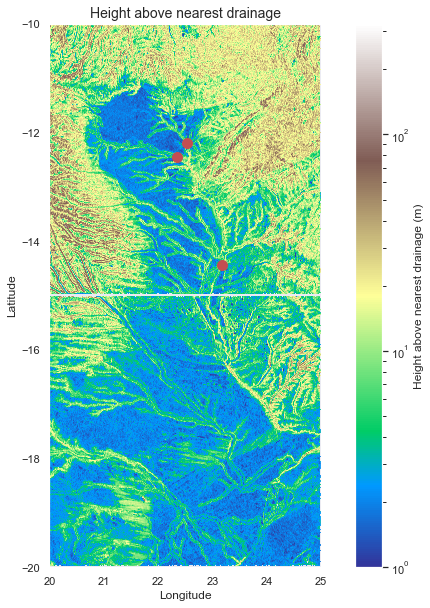

In [6]:

fig, ax = plt.subplots(figsize=(12,10))
plt.imshow(hand +1, zorder=1, cmap='terrain', interpolation='bilinear',
           norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand)),extent=grid.extent)
plt.imshow(hand1 +1 , zorder=1, cmap='terrain', interpolation='bilinear',
            extent=grid1.extent, norm=colors.LogNorm(vmin=1), vmax=np.nanmax(hand1))
plt.colorbar(label='Height above nearest drainage (m)')
plt.title('Height above nearest drainage', size=14)
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0.)


plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/HAND{location}.png'),dpi=400)

plt.show()


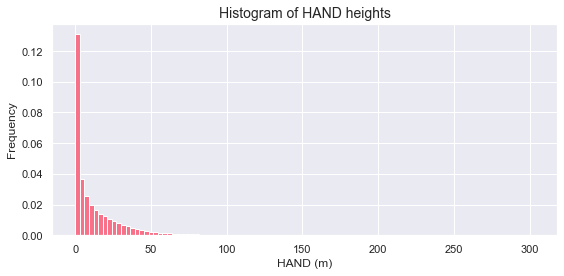

In [12]:

fig, ax = plt.subplots(figsize=(8, 4))
h = plt.hist(hand[~np.isnan(hand)], bins=100, normed=True)
plt.title('Histogram of HAND heights', size=14)
plt.ylabel('Frequency')
plt.xlabel('HAND (m)')
plt.tight_layout()

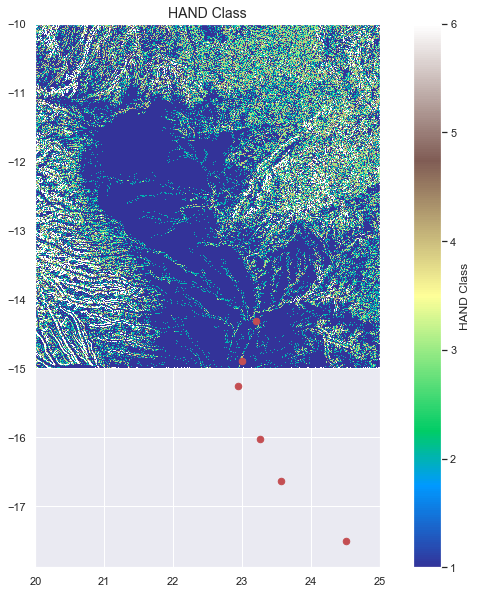

In [118]:
_, bins = np.histogram(hand[~np.isnan(hand) & (hand < 50)], bins=5)
classes = np.digitize(hand, bins)

fig, ax = plt.subplots(figsize=(12,10))
plt.imshow(classes, zorder=1, cmap='terrain', extent=grid.extent)
plt.colorbar(label='HAND Class')
plt.title('HAND Class', size=14)
ax.plot(x, y, color='r', marker='.', markersize=13,linewidth=0.)

In [203]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
grid.clip_to('dir')
# Specify pour point
x, y = 21.5,-12.5

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment

grid.clip_to('catch')
print('the min of catch is:', grid.catch.min())
print('the max of catch is:', grid.catch.max())
print('the mean of catch is:', grid.catch.mean())


plt.imshow(grid.view('catch'))

TypeError: can only concatenate str (not "int") to str

In [192]:
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')
branches = grid.extract_river_network('catch', 'acc', threshold=100, dirmap=dirmap)


In [199]:

grid.clip_to('dir')

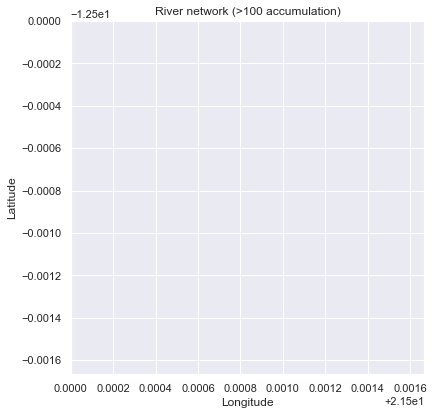

In [193]:

fig, ax = plt.subplots(figsize=(6.5,6.5))

plt.grid('on', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network (>100 accumulation)')
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

In [157]:

grid.fill_depressions(data='dem', out_name='flooded_dem')
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
dirmap = (1, 2, 3, 4, 5, 6, 7, 8)
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap,routing='dinf')

KeyboardInterrupt: 

No handles with labels found to put in legend.


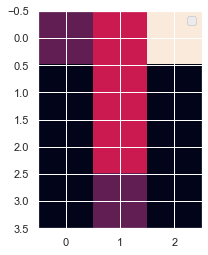

In [200]:
# Specify pour point


# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Plot the result
grid.clip_to('catch')
plt.imshow(grid.view('catch'))
plt.legend()